In [1]:
from chada import Chada

In [2]:
C = Chada(r"C:\Users\barton\Desktop\chada\POLYSTERENE_x20_1%_02.cha")

gx-y(1)


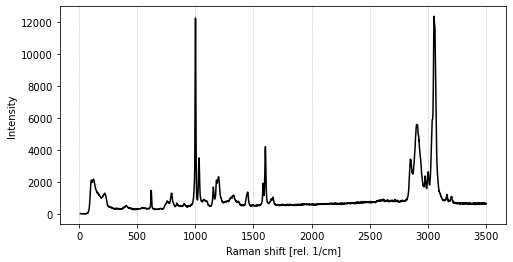

In [3]:
C.plot()

In [422]:
y0 = C.y_data
x0 = C.x_data

In [5]:
shifts = np.ones_like(x0)*100

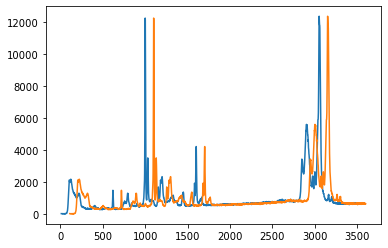

In [7]:
plt.figure()
plt.plot(x0, y0)
plt.plot(x0+shifts, y0)

In [8]:
from scipy.interpolate import interp1d

In [11]:
f_inter = interp1d(x0+shifts, y0, kind="cubic", bounds_error=False, fill_value=0)
y_shifted = f_inter(x0)

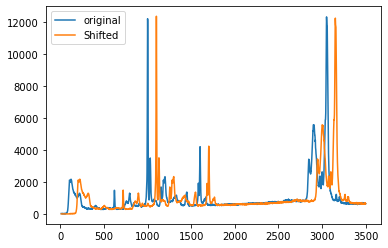

In [14]:
plt.figure()
plt.plot(x0, y0, label="original")
plt.plot(x0, y_shifted, label="Shifted")
plt.legend()

In [78]:
def spec_shift(y0, x0, shifts, show=False):
    f_inter = interp1d(x0+shifts, y0, kind="cubic", bounds_error=False, fill_value=0)
    y_shifted = f_inter(x0)
    if show:
        plt.figure()
        plt.plot(x0, y0, label="original")
        plt.plot(x0, y_shifted, label="Shifted")
        plt.legend()
    return y_shifted

<IPython.core.display.Javascript object>


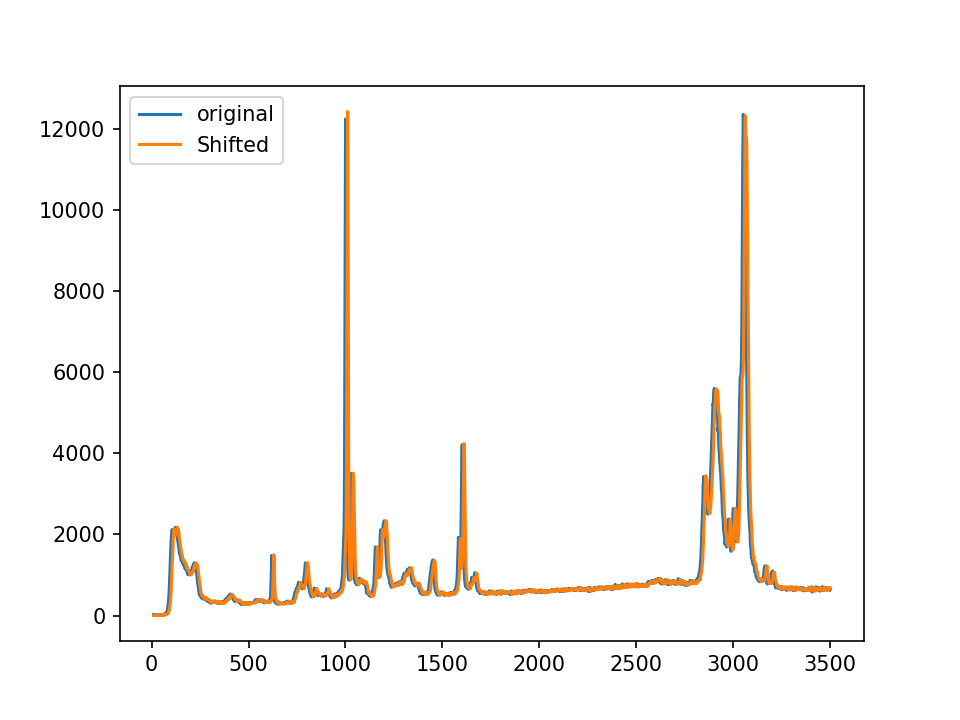

In [376]:
y1 = spec_shift(y0, x0, shifts, True)

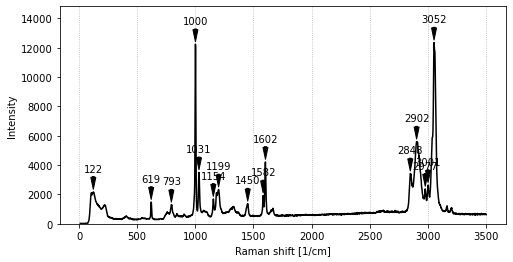

In [41]:
C.peaks(make_plot=True)

In [84]:
peak_pos = np.array(C.bands['peak pos [1/cm]'])

In [344]:
shift_anchors = np.ones_like(peak_pos)*10

In [345]:
f_inter = interp1d(peak_pos, shift_anchors, kind="cubic", bounds_error=False, fill_value="extrapolate")
shifts = f_inter(x0)

In [346]:
plt.plot(x0, shifts)

<IPython.core.display.Javascript object>


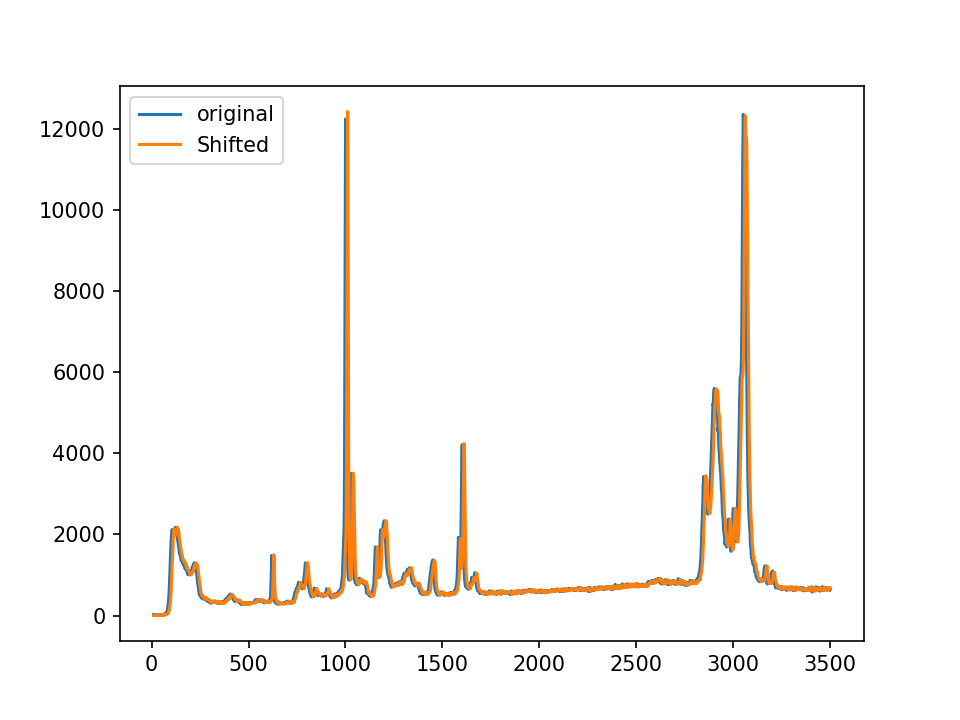

In [347]:
y1 = spec_shift(y0, x0, shifts, True)

In [18]:
hqi = np.linalg.norm(np.dot(y0, y1)) / np.linalg.norm(y0) / np.linalg.norm(y1)

In [19]:
hqi

0.4944831501961566

In [331]:
def hqi(y1, y2):
    return np.linalg.norm(np.dot(y1, y2))**2 / np.linalg.norm(y1)**2 / np.linalg.norm(y2)**2

In [339]:
hqi(y0, spec_shift(y1, x0, shifts))

0.5614823203383457

In [340]:
def align_score(shifts_at_peaks, y, y_ref, x, peak_pos):
    # extrapolate shift vector
    f_inter = interp1d(peak_pos, shifts_at_peaks, kind="cubic", bounds_error=False, fill_value="extrapolate")
    shifts = f_inter(x)
    # calculate HQI of shifted spectrum and ref
    return 1. / hqi(y_ref, spec_shift(y, x, shifts))

In [262]:
shift_anchors

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10.])

In [348]:
align_score(-shift_anchors-10, y1, y0, x0, peak_pos)

1.349110355936117

<IPython.core.display.Javascript object>


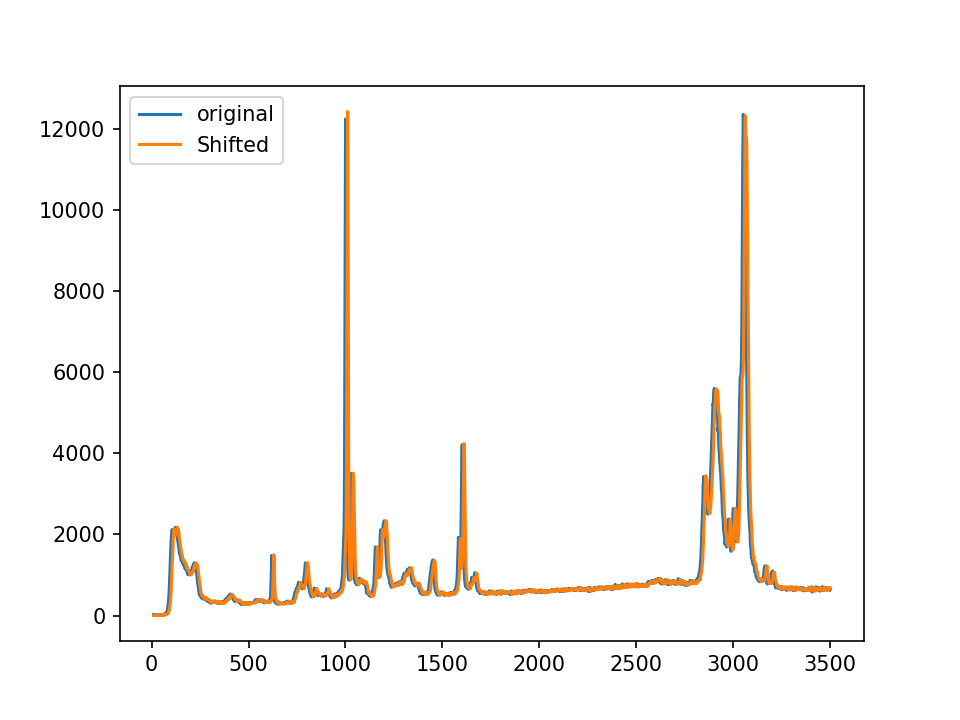

In [349]:
y1 = spec_shift(y0, x0, shifts, True)

In [141]:
hqi(y0, spec_shift(y1, x0, -shifts))

0.9974783235120458

In [162]:
bounds = [[-10., 10.]]*len(shift_anchors)

In [155]:
bounds[0]

[-10.0, 10.0]

In [252]:
align_score(-shift_anchors, *objective_params)

1.0025280514157697

In [253]:
shift_anchors

array([100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100.])

In [130]:
peak_pos

array([ 122.46661394,  619.92181993,  793.69950523, 1000.64087092,
       1031.15145689, 1154.52034797, 1199.62295332, 1450.34037714,
       1582.99509874, 1602.89330698, 2848.52114278, 2902.90957864,
       2977.19622273, 3001.07407262, 3052.80941404])

In [407]:
from scipy.optimize import dual_annealing, fmin

In [375]:
lw = [-10.] * len(peak_pos)
up = [10.] * len(peak_pos)
ret = dual_annealing( align_score, bounds=list(zip(lw, up)), args=objective_params, seed=1234)

TypeError: zip argument #1 must support iteration

In [373]:
ret.x

array([ -9.99989174,  -9.99955857,  -9.99701628,  -9.99910377,
       -10.        ,  -9.99292025, -10.        , -10.        ,
        -9.99169833,  -9.99851933,  -9.99482652,  -9.97451349,
        -9.83825054,  -9.84730857,  -9.96428256])

In [366]:
f_inter = interp1d(peak_pos, ret.x, kind="cubic", bounds_error=False, fill_value=0)
shifts_c = f_inter(x0)

<IPython.core.display.Javascript object>


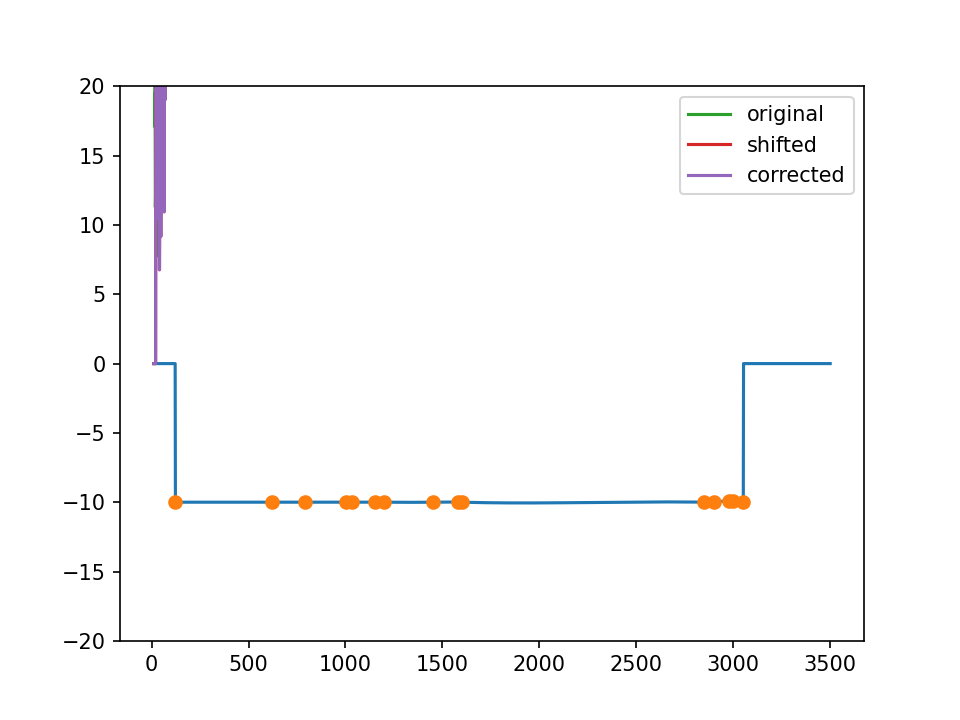

In [367]:
plt.figure()
plt.plot(x0, shifts_c)
plt.plot(peak_pos, ret.x, 'o')
plt.ylim([-20,20])
plt.show()

In [368]:
ycorr = spec_shift(y1, x0, shifts_c)

<IPython.core.display.Javascript object>


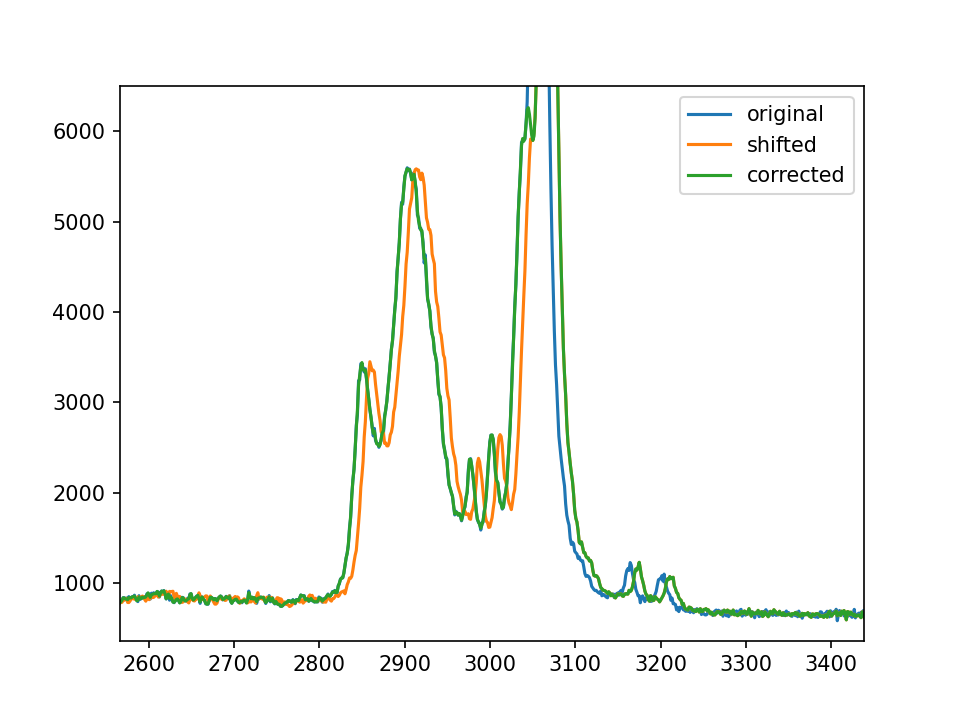

In [370]:
plt.figure()
plt.plot(x0, y0, label='original')
plt.plot(x0, y1, label='shifted')
plt.plot(x0, ycorr, label='corrected')
plt.legend()

In [444]:
def alignSpectraX(target_spectrum, reference_spectrum, common_x, bounds=[-10.,10.], show=False):
    # Get peak positions from target_spectrum
    C.peaks()
    peak_pos = np.array(C.bands['peak pos [1/cm]'])
    # Maximize HQI by simulated annealing
    align_params = [target_spectrum, reference_spectrum, common_x, peak_pos]
    lw = [bounds[0]] * len(peak_pos)
    up = [bounds[1]] * len(peak_pos)
    ret = dual_annealing( align_score, bounds=list(zip(lw, up)), args=align_params, seed=1234)
    peak_shifts = ret.x
    # Calulate shift vector
    f_inter = interp1d(peak_pos, peak_shifts, kind="cubic", bounds_error=False, fill_value="extrapolate")
    shifts_vector = f_inter(common_x)
    aligned_target = spec_shift(target_spectrum, common_x, shifts_vector)
    if show:
        plt.figure()
        plt.plot(common_x, shifts_vector)
        plt.plot(peak_pos, peak_shifts, 'o')
        plt.ylim(bounds)
        plt.show()
        plt.figure()
        plt.plot(common_x, reference_spectrum, label='reference')
        plt.plot(common_x, target_spectrum, label='target')
        plt.plot(common_x, aligned_target, label='aligned target')
        plt.xlabel("Raman shift [rel. 1/cm]")
        plt.yticks([])
        plt.legend()
    # Return aligned target and shift vector
    return aligned_target, shifts_vector, peak_shifts

<IPython.core.display.Javascript object>


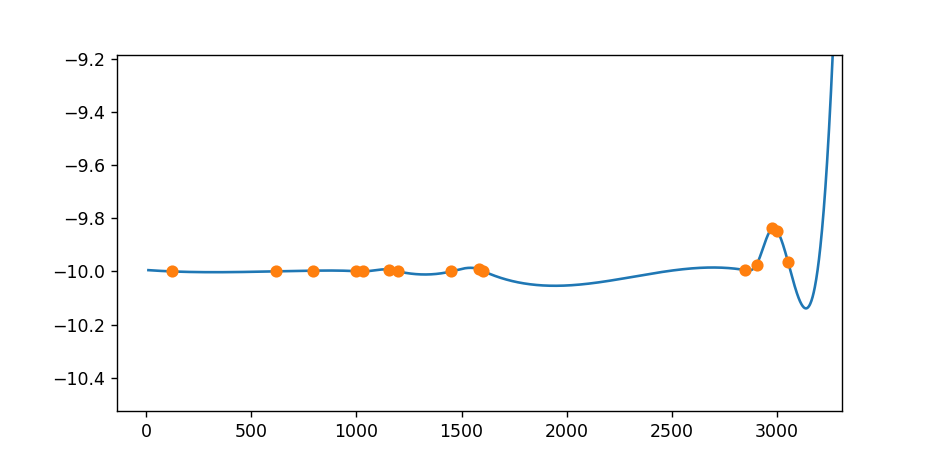

<IPython.core.display.Javascript object>


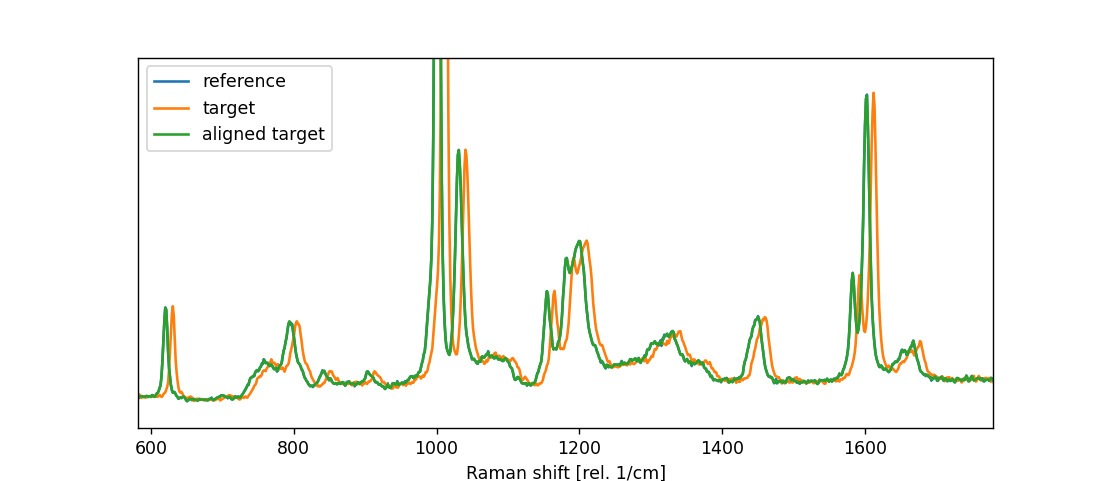

(array([ 14.53043883,  30.76749105,  28.94178897, ..., 668.26062458,
        639.58232366, 659.01127549]),
 array([-9.99510661, -9.9951798 , -9.99525258, ...,  2.50007351,
         2.62179569,  2.74427934]),
 array([ -9.99989174,  -9.99955857,  -9.99701628,  -9.99910377,
        -10.        ,  -9.99292025, -10.        , -10.        ,
         -9.99169833,  -9.99851933,  -9.99482652,  -9.97451349,
         -9.83825054,  -9.84730857,  -9.96428256]))

In [445]:
alignSpectraX(y1, y0, x0, show=True)

In [462]:
def makeXCalFromSpec(target_spectrum, reference_spectrum, common_x, bounds=[-10.,10.]):
    # Get peak positions from target_spectrum
    C.peaks()
    peak_pos = np.array(C.bands['peak pos [1/cm]'])
    # Maximize HQI by simulated annealing
    align_params = [target_spectrum, reference_spectrum, common_x, peak_pos]
    lw = [bounds[0]] * len(peak_pos)
    up = [bounds[1]] * len(peak_pos)
    ret = dual_annealing( align_score, bounds=list(zip(lw, up)), args=align_params, seed=1234)
    return peak_pos, ret.x

In [467]:
def XCal(x, y, x_pos, shifts_pos, show=False):    
    # Calulate shift vector
    f_inter = interp1d(x_pos, shifts_pos, kind="cubic", bounds_error=False, fill_value=0)
    shifts_vector = f_inter(x)
    aligned_target = spec_shift(y, x, shifts_vector)
    bounds = [shifts_vector.min(), shifts_vector.max()]
    if show:
        plt.figure()
        plt.plot(x, shifts_vector)
        plt.plot(x_pos, shifts_pos, 'o')
        plt.ylim(bounds)
        plt.show()
        plt.figure()
        plt.plot(x, y, label='target')
        plt.plot(x, aligned_target, label='aligned target')
        plt.xlabel("Raman shift [rel. 1/cm]")
        plt.yticks([])
        plt.legend()
    # Return aligned target and shift vector
    return aligned_target, shifts_vector

In [449]:
x_pos, shifts_pos = makeXCalFromSpec(y1, y0, x0, bounds=[-10.,10.], show=False)

<IPython.core.display.Javascript object>


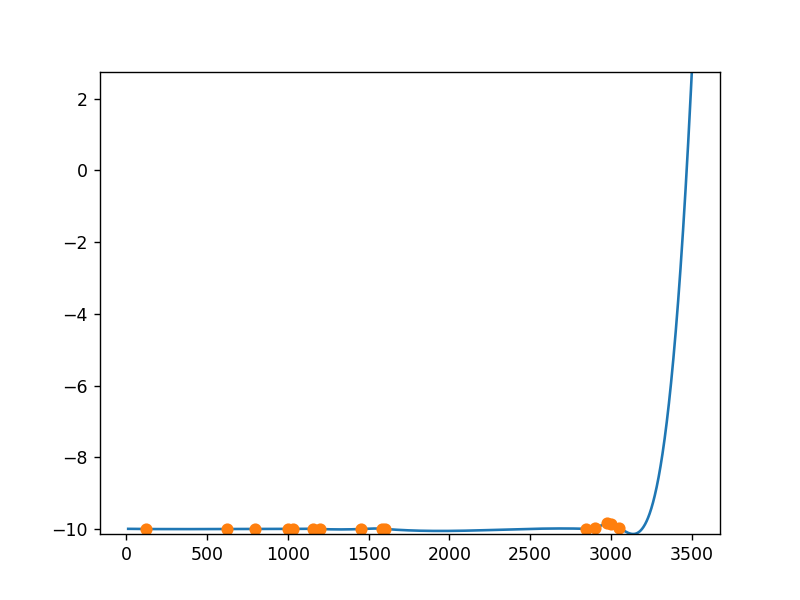

<IPython.core.display.Javascript object>


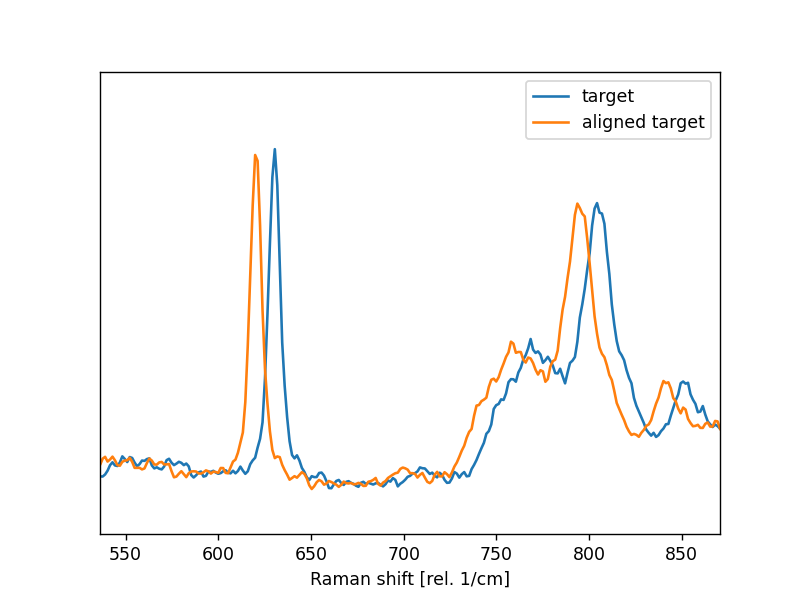

In [451]:
aligned_y1, shifts_vector_y1 = XCal(x0, y1, x_pos, shifts_pos, show=True)

In [388]:
f_inter = interp1d(peak_pos, shift_anchors, kind="cubic", bounds_error=False, fill_value="extrapolate")
shifts = f_inter(x0)

<IPython.core.display.Javascript object>


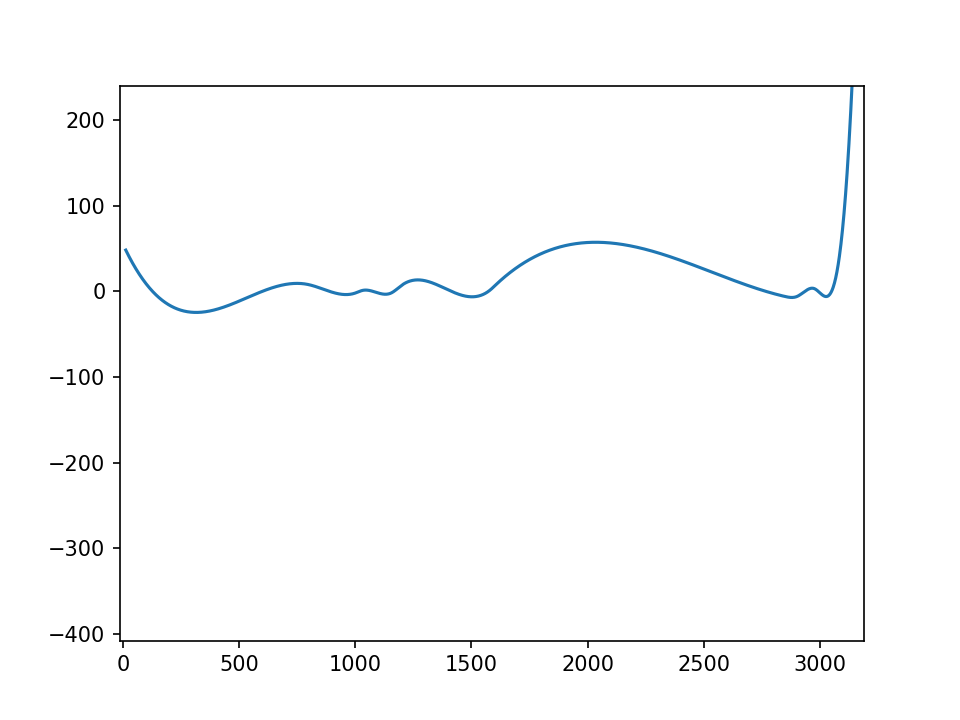

In [390]:
plt.figure()
plt.plot(x0, shifts)
plt.show()

<IPython.core.display.Javascript object>


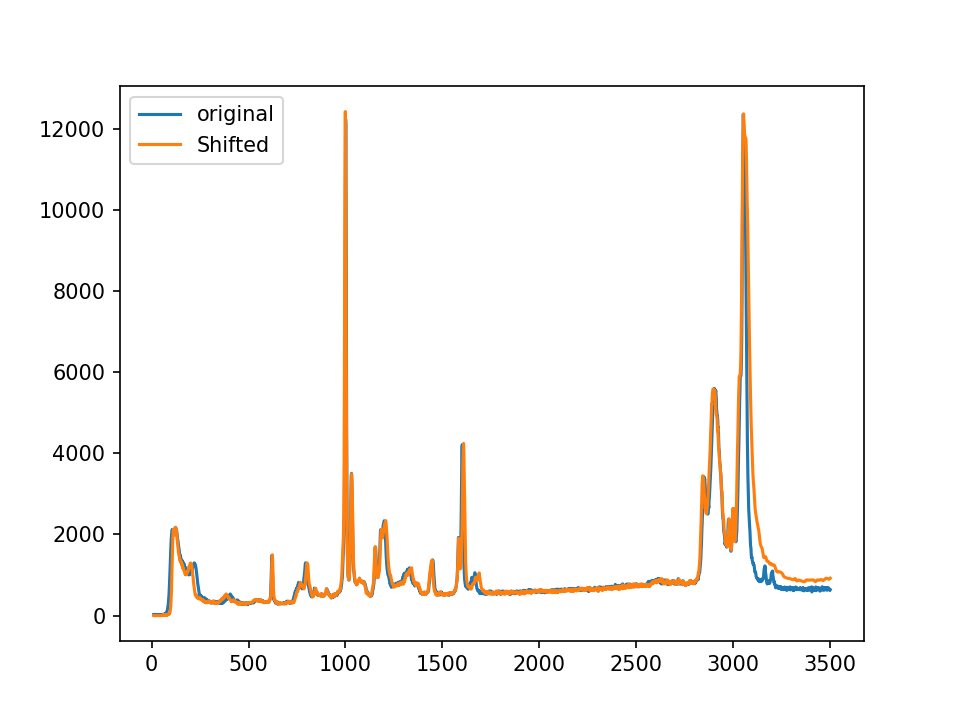

In [391]:
y2 = spec_shift(y0, x0, shifts, True)

In [454]:
from chada import create, Chada

In [456]:
destination_file = r"C:\Users\barton\Desktop\chada\200218-17.cha"

In [470]:
target_file = r"C:/Users/barton/Desktop/chada/200218-17_shifted.cha"

In [471]:
C = Chada(destination_file)
Cs = Chada(target_file)

In [472]:
y0 = C.y_data
x0 = C.x_data
y1 = Cs.y_data

In [473]:
x_pos, shifts_pos = makeXCalFromSpec(y1, y0, x0)

In [474]:
shifts_pos

array([-1.56952437e-05, -8.54510322e-06,  9.83621371e-06,  7.50063556e-04,
        1.66080518e-04, -4.00257745e-04])

<IPython.core.display.Javascript object>


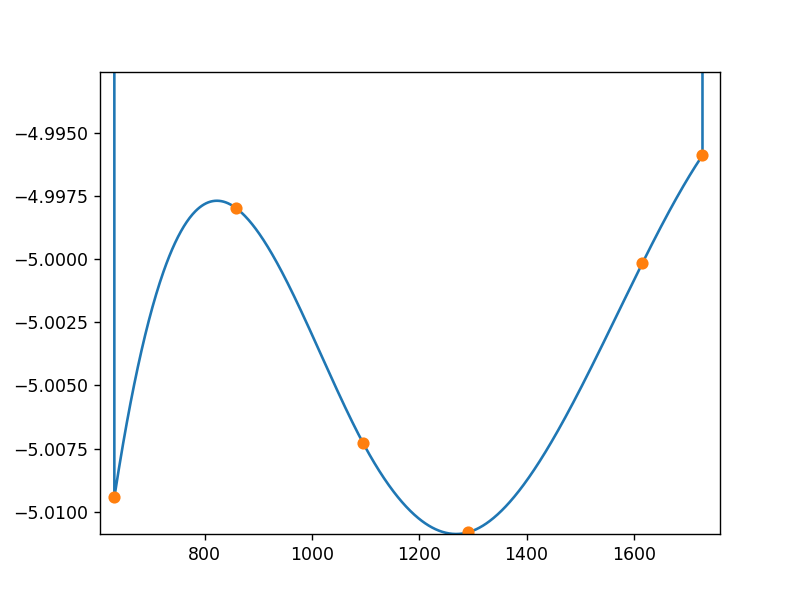

<IPython.core.display.Javascript object>


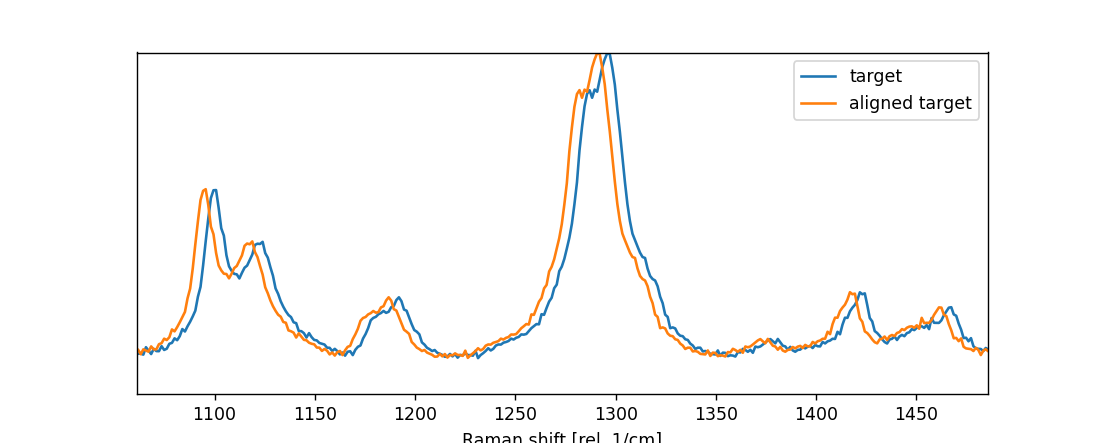

(array([0.00000000e+00, 4.33680869e-19, 3.46944695e-18, ...,
        3.20768825e-01, 2.77117060e-01, 3.47290321e-01]),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [468]:
XCal(x0, y1, x_pos, shifts_pos, show=True)